In [2]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from IPython.display import display
import matplotlib.pyplot as plt
np.random.seed(42)


In [3]:
digits = load_digits(return_X_y=True)
digits_x = digits[0]
digits_y = digits[1]
digits_df = pd.DataFrame(data=digits_x, columns = [f"pixel {i}" for i in range(digits_x.shape[1])])
digits_df['label'] = digits_y

credit_approval = pd.read_csv('credit_approval.csv')
parkinsons = pd.read_csv('parkinsons.csv')
parkinsons.rename(columns={'Diagnosis':'label'},inplace=True)
rice = pd.read_csv('rice.csv')
rice['label'] = rice['label'].map({'Cammeo': 1, 'Osmancik':0})

In [4]:
def construct_folds(dataset, k):
    #divide the dataset into folds with equal length
    shuffled_dataset=shuffle(dataset)
    fold_length, remainder  = divmod(len(dataset), k)

    #calculate the class distribution as a percentage
    label_1_percentage = len(dataset[dataset['label']==1])/len(dataset)
    label_0_percentage = len(dataset[dataset['label']==0])/len(dataset)


    label_1_instances = shuffled_dataset[shuffled_dataset['label']==1]
    label_0_instances = shuffled_dataset[shuffled_dataset['label']==0]

    #get the length that each fold will end up being
    fold_lengths = []
    for i in range(k):
        fold_lengths.append(fold_length)
    i=0
    while remainder>0:
        fold_lengths[i]+=1
        if i == len(fold_lengths)-1:
            i=0
        else:
            i+=1
        remainder -= 1
    
    fold_frames = [pd.DataFrame(index=range(fold_length)) for fold_length in fold_lengths]
    
    j=0
    for fold_length in fold_lengths:
        fold_0_amount = int(fold_length * label_0_percentage)
        fold_1_amount = int(fold_length * label_1_percentage)
        fold_0_rows = label_0_instances.sample(fold_0_amount, replace=False)
        fold_1_rows = label_1_instances.sample(fold_1_amount, replace=False)
        fold_frames[j]=pd.concat([fold_0_rows, fold_1_rows])
        label_1_instances = label_1_instances.drop(fold_1_rows.index).reset_index(drop=True)
        label_0_instances = label_0_instances.drop(fold_0_rows.index).reset_index(drop=True)
        j+=1
    return fold_frames


NEURAL NETWORK FRAMEWORK

In [ ]:
class Layer:
    def __init__(self, num_nuerons):
        self.num_nuerons = num_nuerons
        self.weights = None
        self.next_layer = None
        self.prev_layer = None
        self.z_vals = None
        self.outputs = None
        self.inputs = None
        self.bias_weights = None
        self.deltas = 0
        self.costs = 0
        self.gradients = 0
        self.regularized = 0


def construct_network(layer_arr):
    index = 0
    layers = []
    for layer in layer_arr:
        layers.append(Layer(layer))
    for layer in layers:
        if index==0:
            layer.prev_layer = None
            layer.next_layer = layers[index+1]
            layer.weights = np.round(np.random.uniform(-1,1, size=layers[index+1].num_nuerons * layer.num_nuerons),decimals=2)
        elif index==len(layers)-1:
            layer.next_layer = None
            layer.prev_layer = layers[index-1]
            layer.bias_weights = np.round(np.random.uniform(-1,1, size = layer.num_nuerons),decimals=2)
        else:
            layer.prev_layer = layers[index-1]
            layer.next_layer = layers[index+1]
            layer.bias_weights = np.random.uniform(-1,1, size = layer.num_nuerons)
            layer.weights = np.round(np.random.uniform(-1,1, size=layers[index+1].num_nuerons * layer.num_nuerons),decimals=2)
        index+=1
    return layers



def forward_pass(layers, inputs):
    layers[0].inputs = inputs
    index=0
    for layer in layers:
        if index!=len(layers)-1:
            layer.inputs = layer.inputs.reshape(len(layer.inputs),1)
            layer.next_layer.bias_weights=layer.next_layer.bias_weights.reshape(layer.next_layer.num_nuerons,1)
            layer.weights = layer.weights.reshape(layer.next_layer.num_nuerons,layer.num_nuerons)
            layer.z_vals = (layer.weights @ layer.inputs) + layer.next_layer.bias_weights
            layer.outputs = 1 / (1+np.exp(-layer.z_vals))
            layer.next_layer.inputs = layer.outputs
        else:
            layer.outputs= layer.inputs
        index+=1
    for layer in layers[:-1]:
        layer.inputs = np.vstack([1.0, layer.inputs])

def cost_function(actual, predicted):
    return np.sum((-1*actual) * np.log(predicted) - (1-actual) * np.log(1-predicted))

def regularized_cost(layers, regulariz_term, training_instances, average_error):
    sum_weights = 0
    for layer in layers:
        if layer.weights is not None:
            sum_weights += np.sum(np.square(layer.weights)) 
    regularizer = (regulariz_term/(2*training_instances))*sum_weights
    return average_error + regularizer


def accumulator(layers, actual):
    layers[-1].deltas = layers[-1].outputs.flatten() - actual
    i = len(layers)-2
    while i>0:
        inputs_without_bias= layers[i].inputs.copy()[1:]
        layers[i].deltas = ((layers[i].weights).T @ layers[i+1].deltas.reshape(-1,1)) * (inputs_without_bias * (1-inputs_without_bias))
        i-=1
    i=len(layers)-2
    while i>=0:
        layers[i].gradients = layers[i].gradients + (layers[i+1].deltas.reshape(-1,1) @ layers[i].inputs.T)
        i-=1
    
def update_weights(layers,learning_rate, regularizer, instance_count):
    i=len(layers)-2
    while i>=0:
        layers[i].weights = np.hstack([layers[i+1].bias_weights, layers[i].weights])
        regularize = np.dot(regularizer, layers[i].weights)
        regularize[:,0]=0
        layers[i].gradients = (1/instance_count) * (layers[i].gradients + regularize)
        layers[i].weights = layers[i].weights - (learning_rate * layers[i].gradients)
        layers[i+1].bias_weights = layers[i].weights[:,0].reshape(-1,1)
        layers[i].weights = np.delete(layers[i].weights, 0, axis=1)
        i-=1


def training_loop(layers, training_data:np.array, learning_rate, regularizer, epochs):
    epoch_regularized_cost = []
    for j in range(epochs):
        total_cost = 0
        
        for i in range(len(training_data)):
            vals = training_data[i,:-1]
            actual = training_data[i,-1:].flatten()
            forward_pass(layers, vals)
            accumulator(layers, actual)
            total_cost += cost_function(actual, layers[-1].outputs.flatten())
            
        average_cost = total_cost / len(training_data)
        regularized_cost_of_set = regularized_cost(layers, regularizer, len(training_data),average_cost)
        update_weights(layers, learning_rate, regularizer, len(training_data))
        epoch_regularized_cost.append(regularized_cost_of_set)
        
    return layers, epoch_regularized_cost


def test(layers, test_data):
    forward_pass(layers, test_data)
    if layers[-1].outputs.flatten()[0] < 0.5:
        return 0
    else:
        return 1

def normalize(train_set, test_set,norm_columns):
    train_norm = train_set.copy()
    test_norm  = test_set.copy()
    for col in norm_columns:
        min = train_norm[col].min()
        max = train_norm[col].max()
        if max==min:
            continue
        values = train_norm[col]
        normalized = (values - min)/(max-min)
        train_norm[col]=normalized
        test_norm[col]= (test_norm[col]-min)/(max-min)
    return train_norm, test_norm


PARKINSONS DATASET

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,11,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8421052631578947, 0.9032258064516129],
 [0.9473684210526315, 0.967741935483871],
 [0.8421052631578947, 0.9032258064516129],
 [0.8421052631578947, 0.9090909090909091],
 [0.8421052631578947, 0.9032258064516129],
 [0.8333333333333334, 0.9032258064516129],
 [0.8888888888888888, 0.9333333333333333],
 [0.8333333333333334, 0.896551724137931],
 [0.6666666666666666, 0.7692307692307692],
 [0.9444444444444444, 0.9655172413793104]]

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,11,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8947368421052632, 0.9333333333333333],
 [0.8421052631578947, 0.9032258064516129],
 [0.7368421052631579, 0.8387096774193549],
 [0.7894736842105263, 0.8749999999999999],
 [0.8947368421052632, 0.9375],
 [0.8333333333333334, 0.896551724137931],
 [0.8888888888888888, 0.9333333333333333],
 [0.8333333333333334, 0.896551724137931],
 [0.7777777777777778, 0.8666666666666666],
 [0.8888888888888888, 0.9333333333333333]]

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,5,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.01, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.7894736842105263, 0.8823529411764706],
 [0.7894736842105263, 0.8823529411764706],
 [0.7894736842105263, 0.8823529411764706],
 [0.7894736842105263, 0.8823529411764706],
 [0.7894736842105263, 0.8823529411764706],
 [0.7777777777777778, 0.8750000000000001],
 [0.7777777777777778, 0.8750000000000001],
 [0.7777777777777778, 0.8750000000000001],
 [0.7777777777777778, 0.8750000000000001],
 [0.7777777777777778, 0.8750000000000001]]

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,5,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8947368421052632, 0.9375],
 [0.8421052631578947, 0.9032258064516129],
 [0.8947368421052632, 0.9375],
 [0.8947368421052632, 0.9375],
 [0.7894736842105263, 0.8749999999999999],
 [0.8888888888888888, 0.9333333333333333],
 [0.8888888888888888, 0.9285714285714286],
 [0.7777777777777778, 0.8666666666666666],
 [0.8888888888888888, 0.9285714285714286],
 [0.8333333333333334, 0.888888888888889]]

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,10,5,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8421052631578947, 0.9090909090909091],
 [0.7368421052631579, 0.8484848484848485],
 [0.8421052631578947, 0.9032258064516129],
 [0.8421052631578947, 0.9032258064516129],
 [1.0, 1.0],
 [0.8333333333333334, 0.896551724137931],
 [1.0, 1.0],
 [0.9444444444444444, 0.9655172413793104],
 [0.7777777777777778, 0.8666666666666666],
 [0.8333333333333334, 0.888888888888889]]

In [ ]:
fold_frames = construct_folds(parkinsons, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([22,11,5,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, parkinsons.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8421052631578947, 0.896551724137931],
 [0.7894736842105263, 0.8823529411764706],
 [0.8947368421052632, 0.9285714285714286],
 [0.8947368421052632, 0.9333333333333333],
 [1.0, 1.0],
 [0.8888888888888888, 0.9333333333333333],
 [0.8333333333333334, 0.9032258064516129],
 [0.7222222222222222, 0.8275862068965518],
 [0.8888888888888888, 0.9333333333333333],
 [0.8888888888888888, 0.9333333333333333]]

In [22]:
def training_loop_2(layers, training_data:np.array, test_data, learning_rate, regularizer, epochs):
    epoch_regularized_cost = []
    test_cost_arr = {}
    for j in range(epochs):
        test_cost = 0
        for i in range(len(test_data)):
            vals = test_data[i, :-1]
            actual = test_data[i, -1:].flatten()
            forward_pass(layers, vals)
            test_cost+=(cost_function(actual, layers[-1].outputs.flatten()))
        average_cost_1 = test_cost / len(test_data)
        regularized_test_cost = regularized_cost(layers, regularizer, len(test_data),average_cost_1)
        test_cost_arr.update({j*len(training_data):regularized_test_cost})

        total_cost = 0
        for i in range(len(training_data)):
            vals = training_data[i,:-1]
            actual = training_data[i,-1:].flatten()
            forward_pass(layers, vals)
            accumulator(layers, actual)
            total_cost += cost_function(actual, layers[-1].outputs.flatten())
            
        average_cost = total_cost / len(training_data)
        regularized_cost_of_set = regularized_cost(layers, regularizer, len(training_data),average_cost)
        update_weights(layers, learning_rate, regularizer, len(training_data))
        epoch_regularized_cost.append(regularized_cost_of_set)
        
    return layers, epoch_regularized_cost, test_cost_arr

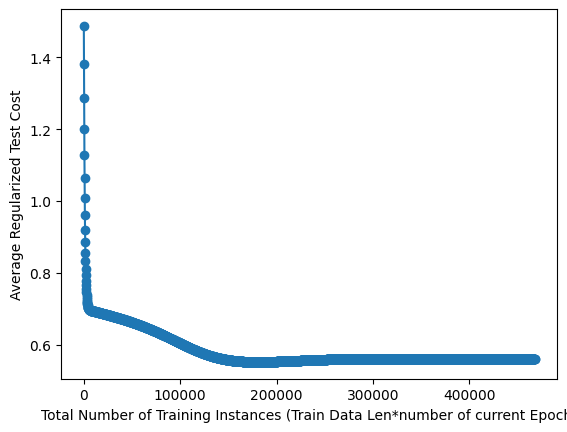

In [ ]:
from sklearn.model_selection import train_test_split



train,test = train_test_split(parkinsons, test_size=0.2, random_state=0, stratify=parkinsons['label'])
train_norm_1, test_norm_1 = normalize(train,test)
train_norm_num = train_norm_1.to_numpy()
test_norm_num = test_norm_1.to_numpy()
layers = construct_network([22,10,5,1])
layers,epoch_costs,test_cost = training_loop_2(layers, train_norm_num, test_norm_num, 0.1, 0.1,3000)

plt.plot(test_cost.keys(), test_cost.values(), marker='o')
plt.ylabel('Average Regularized Test Cost')
plt.xlabel('Total Number of Training Instances (Train Data Len*number of current Epoch)')
plt.show()

CREDIT APPROVAL

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['attr1_cat','attr4_cat', 'attr5_cat','attr6_cat','attr7_cat','attr9_cat','attr10_cat','attr11_cat','attr12_cat','attr13_cat']

transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), categorical)],
    remainder='passthrough'
)
credit_transformer = pd.DataFrame(transformer.fit_transform(credit_approval), columns=transformer.get_feature_names_out())

credit_transformer.columns = credit_transformer.columns.str.strip()
credit_transformer.rename(columns={'remainder__label':'label'},inplace=True)
credit_transformer.head()
len(credit_transformer.columns)


69

In [26]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 35, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,1000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8769230769230769, 0.8750000000000001],
 [0.9076923076923077, 0.8928571428571429],
 [0.8769230769230769, 0.8787878787878788],
 [0.84375, 0.8484848484848485],
 [0.828125, 0.8070175438596492],
 [0.890625, 0.8813559322033899],
 [0.859375, 0.847457627118644],
 [0.84375, 0.8437500000000001],
 [0.859375, 0.8524590163934426],
 [0.859375, 0.8571428571428571]]

In [27]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 35, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,3000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8461538461538461, 0.8437500000000001],
 [0.9076923076923077, 0.8928571428571429],
 [0.9230769230769231, 0.9090909090909091],
 [0.859375, 0.847457627118644],
 [0.8125, 0.8125],
 [0.875, 0.8571428571428572],
 [0.828125, 0.8253968253968255],
 [0.859375, 0.8524590163934426],
 [0.796875, 0.7868852459016394],
 [0.84375, 0.8275862068965517]]

In [28]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 35, 17, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,1000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.9384615384615385, 0.9333333333333333],
 [0.9384615384615385, 0.9259259259259259],
 [0.8461538461538461, 0.8387096774193549],
 [0.875, 0.8666666666666666],
 [0.859375, 0.8571428571428571],
 [0.859375, 0.8615384615384615],
 [0.78125, 0.7812500000000001],
 [0.890625, 0.8813559322033899],
 [0.828125, 0.8070175438596492],
 [0.953125, 0.9473684210526316]]

In [29]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 35, 17, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8923076923076924, 0.8727272727272727],
 [0.8, 0.8059701492537312],
 [0.9384615384615385, 0.9333333333333333],
 [0.84375, 0.8275862068965517],
 [0.890625, 0.8813559322033899],
 [0.84375, 0.8333333333333334],
 [0.890625, 0.8852459016393444],
 [0.8125, 0.8181818181818181],
 [0.875, 0.8666666666666666],
 [0.8125, 0.7692307692307693]]

In [30]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 35, 17, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,500)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8769230769230769, 0.8571428571428572],
 [0.9076923076923077, 0.9],
 [0.8923076923076924, 0.8813559322033899],
 [0.8125, 0.7857142857142857],
 [0.78125, 0.7666666666666667],
 [0.890625, 0.888888888888889],
 [0.8125, 0.7777777777777777],
 [0.875, 0.8750000000000001],
 [0.921875, 0.9152542372881356],
 [0.78125, 0.7741935483870968]]

In [32]:
fold_frames = construct_folds(credit_transformer, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([68, 17, 1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    norm_columns = ['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num']
    train_norm, test_norm = normalize(train_set, test_fold,norm_columns)
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 0.1, 0.1,1000)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.8769230769230769, 0.8750000000000001],
 [0.8769230769230769, 0.8620689655172413],
 [0.8461538461538461, 0.8333333333333334],
 [0.796875, 0.7796610169491527],
 [0.90625, 0.9],
 [0.828125, 0.8307692307692308],
 [0.90625, 0.9032258064516129],
 [0.90625, 0.9],
 [0.796875, 0.7868852459016394],
 [0.875, 0.8571428571428572]]

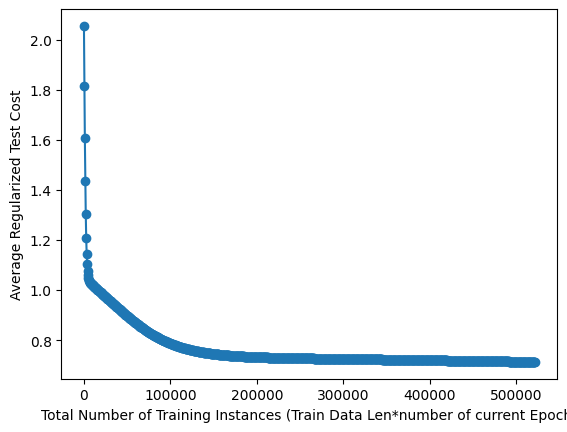

In [38]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(credit_transformer, test_size=0.2, random_state=0, stratify=credit_transformer['label'])
train_norm_1, test_norm_1 = normalize(train,test,['remainder__attr2_num', 'remainder__attr3_num', 'remainder__attr8_num',
       'remainder__attr14_num', 'remainder__attr15_num'])
train_norm_num = train_norm_1.to_numpy()
test_norm_num = test_norm_1.to_numpy()
layers = construct_network([68,35,17,1])
layers,epoch_costs,test_cost = training_loop_2(layers, train_norm_num, test_norm_num, 0.1, 0.1,1000)
plt.plot(test_cost.keys(), test_cost.values(), marker='o')
plt.ylabel('Average Regularized Test Cost')
plt.xlabel('Total Number of Training Instances (Train Data Len*number of current Epoch)')
plt.show()

RICE DATASET

In [14]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.926509186351706, 0.9130434782608695],
 [0.926509186351706, 0.9141104294478528],
 [0.9291338582677166, 0.9164086687306502],
 [0.9081364829396326, 0.8909657320872275],
 [0.905511811023622, 0.8909090909090909],
 [0.9081364829396326, 0.8929663608562691],
 [0.931758530183727, 0.9192546583850932],
 [0.952755905511811, 0.9447852760736196],
 [0.9028871391076115, 0.8817891373801918],
 [0.9291338582677166, 0.9153605015673982]]

In [15]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,3,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.9238845144356955, 0.9085173501577286],
 [0.9238845144356955, 0.913946587537092],
 [0.9002624671916011, 0.8827160493827161],
 [0.937007874015748, 0.9272727272727274],
 [0.968503937007874, 0.9631901840490797],
 [0.952755905511811, 0.9451219512195123],
 [0.9212598425196851, 0.9074074074074073],
 [0.905511811023622, 0.8895705521472392],
 [0.910761154855643, 0.891025641025641],
 [0.9081364829396326, 0.891640866873065]]

In [18]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,3,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.3,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.9133858267716536, 0.8996960486322187],
 [0.952755905511811, 0.9444444444444444],
 [0.926509186351706, 0.9141104294478528],
 [0.937007874015748, 0.9272727272727274],
 [0.905511811023622, 0.8860759493670887],
 [0.9291338582677166, 0.9164086687306502],
 [0.9238845144356955, 0.9113149847094801],
 [0.931758530183727, 0.9221556886227544],
 [0.9291338582677166, 0.9158878504672897],
 [0.9238845144356955, 0.9090909090909092]]

In [19]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,5,3,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,300)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.910761154855643, 0.8944099378881988],
 [0.9343832020997376, 0.923076923076923],
 [0.9212598425196851, 0.9107142857142857],
 [0.9238845144356955, 0.9107692307692307],
 [0.9212598425196851, 0.9074074074074073],
 [0.9396325459317585, 0.9283489096573209],
 [0.9396325459317585, 0.9300911854103343],
 [0.9081364829396326, 0.8909657320872275],
 [0.937007874015748, 0.9259259259259259],
 [0.9212598425196851, 0.9068322981366461]]

In [20]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,5,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,500)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.931758530183727, 0.9216867469879518],
 [0.910761154855643, 0.8963414634146343],
 [0.9396325459317585, 0.9292307692307692],
 [0.9291338582677166, 0.9169230769230768],
 [0.931758530183727, 0.91875],
 [0.926509186351706, 0.9141104294478528],
 [0.916010498687664, 0.9024390243902439],
 [0.931758530183727, 0.9207317073170732],
 [0.9396325459317585, 0.9283489096573209],
 [0.9343832020997376, 0.923076923076923]]

In [21]:
fold_frames = construct_folds(rice, 10)
accuracy_f1 = []
for i in range(10):
    layers = construct_network([7,3,1])
    test_fold = fold_frames.pop(0)
    train_set = pd.concat(fold_frames)
    train_norm, test_norm = normalize(train_set, test_fold, rice.columns[:-1])
    test_fold_num = test_norm.to_numpy()
    train_set_num = train_norm.to_numpy()
    layers, epoch_costs = training_loop(layers, train_set_num, 1, 0.1,500)
    tp=0
    fp=0
    tn=0
    fn=0
    k=0
    while k<len(test_fold_num):
        data = test_fold_num[k][:-1]
        actual = test_fold_num[k][-1:].flatten()
        prediction = test(layers,data)
        if prediction == actual[0]==1:
            tp+=1
        elif prediction == actual[0]==0:
            tn+=1
        elif prediction == 1 and actual[0]==0:
            fp+=1
        elif prediction == 0 and actual[0]==1:
            fn+=1
        k+=1
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy_f1.append([accuracy,f1_score])
    fold_frames.append(test_fold)
accuracy_f1

[[0.9238845144356955, 0.9055374592833877],
 [0.9343832020997376, 0.924924924924925],
 [0.926509186351706, 0.9135802469135801],
 [0.910761154855643, 0.9],
 [0.9186351706036745, 0.9028213166144201],
 [0.952755905511811, 0.9447852760736196],
 [0.931758530183727, 0.9192546583850932],
 [0.9291338582677166, 0.9164086687306502],
 [0.937007874015748, 0.9263803680981595],
 [0.9186351706036745, 0.906344410876133]]

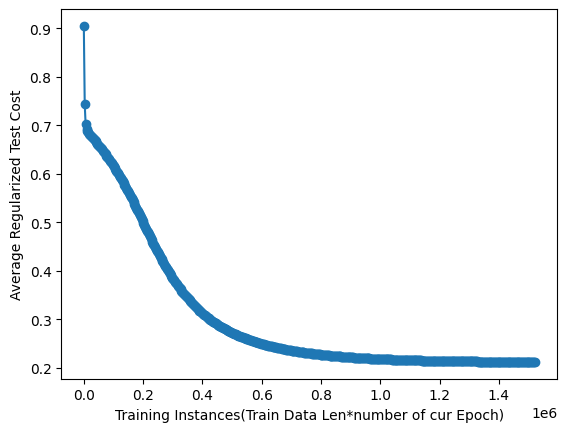

dict_keys([0, 3048, 6096, 9144, 12192, 15240, 18288, 21336, 24384, 27432, 30480, 33528, 36576, 39624, 42672, 45720, 48768, 51816, 54864, 57912, 60960, 64008, 67056, 70104, 73152, 76200, 79248, 82296, 85344, 88392, 91440, 94488, 97536, 100584, 103632, 106680, 109728, 112776, 115824, 118872, 121920, 124968, 128016, 131064, 134112, 137160, 140208, 143256, 146304, 149352, 152400, 155448, 158496, 161544, 164592, 167640, 170688, 173736, 176784, 179832, 182880, 185928, 188976, 192024, 195072, 198120, 201168, 204216, 207264, 210312, 213360, 216408, 219456, 222504, 225552, 228600, 231648, 234696, 237744, 240792, 243840, 246888, 249936, 252984, 256032, 259080, 262128, 265176, 268224, 271272, 274320, 277368, 280416, 283464, 286512, 289560, 292608, 295656, 298704, 301752, 304800, 307848, 310896, 313944, 316992, 320040, 323088, 326136, 329184, 332232, 335280, 338328, 341376, 344424, 347472, 350520, 353568, 356616, 359664, 362712, 365760, 368808, 371856, 374904, 377952, 381000, 384048, 387096, 39014

In [29]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(rice, test_size=0.2, random_state=0, stratify=rice['label'])
train_norm_1, test_norm_1 = normalize(train,test,rice.columns[:-1])
train_norm_num = train_norm_1.to_numpy()
test_norm_num = test_norm_1.to_numpy()
layers = construct_network([7,5,1])
layers,epoch_costs,test_cost = training_loop_2(layers, train_norm_num, test_norm_num, 1, 0.1,500)
plt.plot(test_cost.keys(), test_cost.values(), marker='o')
plt.ticklabel_format(axis='x', style='sci', scilimits=(6,6))
plt.ylabel('Average Regularized Test Cost')
plt.xlabel('Training Instances(Train Data Len*number of cur Epoch)')
plt.show()
print(test_cost.keys())
print(test_cost.values())